In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
#matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import math
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import svm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
ds_original = pd.read_csv('dataset_phishing.csv', header=0, delimiter=',',decimal=',')

print("Original dataset dimensions:", ds_original.shape)

#Podem prescindir de la columna de strings amb la url perquè toda la informació que ens pot donar ja queda reflexada en la resta de característiques
dataset = ds_original.drop(columns = "url")

Original dataset dimensions: (11430, 89)


In [3]:
# L' objectiu és predir si una url és de phishing o no, per tant la variable dependent serà STATUS.
y = dataset[:]["status"] 
x = dataset.drop(columns = "status")

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 87


In [4]:
print(y.describe())
y = y.replace({"phishing" : 1, "legitimate" : 0})

print("\nContingut de Y:", set(y))

print("\nDimensionalitat de X:", x.shape)

count        11430
unique           2
top       phishing
freq          5715
Name: status, dtype: object

Contingut de Y: {0, 1}

Dimensionalitat de X: (11430, 87)


Incialment a $Y$ teniem les etiques de "phishing" i "legitimate". Per poder fer regressió ens interessa convertir-les en un valor binari on 1 indica _Phishing_ i 0 no.
També veïem que les mostres estan repartides al 50% entre les dues categoríes (Com s'indica a la descripció de Kaggle).

Les columnes de $X$ que tenen nombres decimals apareixen amb un tipus de dada desconegut anomenat _object_. Aixó pot crear problemes més endavant, per tant es bona idea fer una conversió a tipus _float_.

In [5]:
type_of_cols = [x.dtypes == object][0]
for col in range(x.shape[1]):
    if type_of_cols[col]:
        x[x.columns[col]] = x[x.columns[col]].astype('float')

Now $X$ contain just numeric values.

A good idea for discarding some columns would be to drop those whose mean is or is very close to 0. We can do this only with the features that represent some kind of counter because that means that most of the samples doesn't register that feature.

In [6]:
columns_to_drop = []

for col in range(x.shape[1]):
    name_of_feature = x.columns[col]
    if np.mean(x[name_of_feature]) <= 0.01:
        columns_to_drop.append(name_of_feature)
        
x[columns_to_drop].describe()

,nb_or,nb_tilde,nb_star,nb_comma,nb_dollar,nb_dslash,punycode,port,path_extension,nb_external_redirection,brand_in_subdomain,brand_in_path,ratio_nullHyperlinks,ratio_intRedirection,ratio_intErrors,submit_email,sfh,iframe,popup_window,onmouseover,right_clic
count,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000,11430.000
mean,0.000,0.007,0.001,0.004,0.002,0.007,0.000,0.002,0.000,0.003,0.004,0.005,0.000,0.000,0.000,0.000,0.000,0.001,0.006,0.001,0.001
std,0.000,0.081,0.026,0.103,0.077,0.081,0.019,0.049,0.013,0.056,0.064,0.070,0.000,0.000,0.000,0.000,0.000,0.036,0.077,0.034,0.037
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,0.000,1.000,1.000,4.000,6.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000


Veient els màxims i mínims d'aquestes columnes queda clar que totes aquestes columnes indiquen un compte d'alguna cosa o són variables binaries i, en qualsevol cas, no donen suficient informació per ajudar en la classifició. 

In [7]:
x = x.drop(columns = columns_to_drop)
print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 66


Funcions de regressio

In [8]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()


def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    
    # Retornem el model entrenat
    return regr

In [9]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x.values, y)

r2_table = np.zeros((x_train.shape[1], 2))

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)
    r2 = r2_score(y_val, regr.predict(x_v))
    
    r2_table[i, 1] = r2
    r2_table[i, 0] = i

We create a reduced dataset with the best atributes

In [10]:
best_atributes = r2_table[r2_table[:, 1].argsort()[::-1]][:,0].astype('int')

reduced_dataset = x[x.columns[best_atributes[:15]]]
reduced_dataset = reduced_dataset.assign(status = y.values)

X = reduced_dataset.drop(columns='status').values
Y = reduced_dataset.filter(['status']).values


# Mirar domain_age (tiene -1 cuando no conoce la info)

In [11]:
known_domain_age = reduced_dataset.loc[reduced_dataset['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)
mean_domain_age

4812.587418385325

In [12]:
reduced_dataset[reduced_dataset["domain_age"] == -1]["domain_age"] = mean_domain_age

<ipython-input-12-0b17bd142d8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_dataset[reduced_dataset["domain_age"] == -1]["domain_age"] = mean_domain_age


In [13]:
reduced_dataset.loc[reduced_dataset["domain_age"] == -1, 'domain_age'] = mean_domain_age

In [14]:
reduced_dataset

,google_index,page_rank,nb_www,ratio_digits_url,domain_in_title,ip,phish_hints,domain_age,nb_hyperlinks,nb_qm,ratio_intHyperlinks,nb_slash,length_url,shortest_word_host,ratio_intMedia,status
0,1,4,1,0.000,0,0,0,4812.587,17,0,0.529,3,37,3,100.000,0
1,1,2,0,0.221,1,1,0,5767.000,30,0,0.967,5,77,19,80.000,1
2,1,0,0,0.151,1,1,0,4004.000,4,1,1.000,5,126,3,0.000,1
3,0,3,0,0.000,1,0,0,4812.587,149,0,0.973,2,18,5,96.429,0
4,0,6,1,0.000,0,0,0,8175.000,102,0,0.471,5,55,3,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,6,1,0.000,0,0,0,5396.000,199,0,0.884,4,45,3,21.053,0
11426,1,0,1,0.024,1,0,0,6728.000,3,1,1.000,5,84,3,0.000,1
11427,1,10,1,0.143,0,1,0,8515.000,68,1,0.471,5,105,3,0.000,0
11428,0,4,1,0.000,1,0,0,2836.000,32,0,0.375,3,38,3,0.000,0


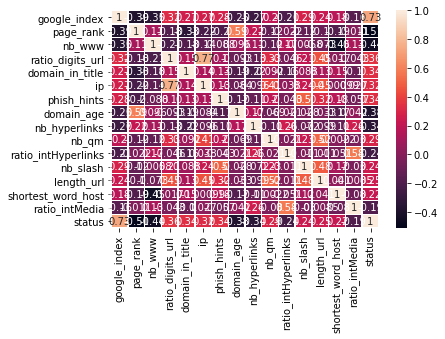

In [15]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
#relacio = sns.pairplot(smaller)

PCA Analysis

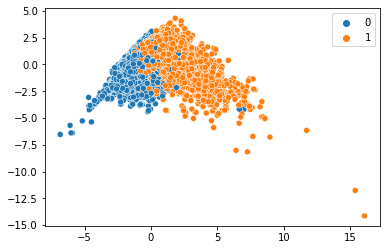

In [16]:

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=2)[2]
pca = torch.matmul(X_torch, V[:, :2])


class1 = (Y_torch == 0).flatten().tolist()
class2 = (Y_torch == 1).flatten().tolist()


sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = Y.flatten());


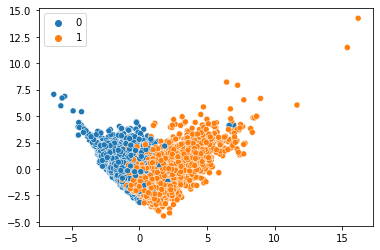

In [17]:


scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(scaled_X)
pca = pca.transform(scaled_X)


sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = Y.flatten());



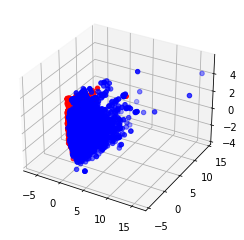

In [18]:

fig = plt.figure()



scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca.fit(scaled_X)
pca = pca.transform(scaled_X)

ax = fig.add_subplot(111, projection = '3d')

#ax.scatter(xs = pca[:, 0], ys = pca[:, 1], zs = pca[:, 0], label = Y.flatten());
class0 = (Y_torch == 0).flatten().tolist()
class1 = (Y_torch == 1).flatten().tolist()
ax.scatter(xs = pca[class0, 0], ys = pca[class0, 1], zs = pca[class0, 2], color = "red");
ax.scatter(xs = pca[class1, 0], ys = pca[class1, 1], zs = pca[class1, 2], color = "blue");

plt.show()

#### Logistic regression

In [19]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

In [20]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [21]:
epochs = 2000
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.01

In [22]:


model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%(epochs/5)==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = model(X_test)
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(outputs.round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  37%|███▋      | 734/2000 [00:00<00:01, 1182.10it/s]

Iteration: 400. 
Test - Loss: 0.2979845702648163. Accuracy: 90.71522309711285
Train -  Loss: 0.2869316041469574. Accuracy: 91.46981627296589

Iteration: 800. 
Test - Loss: 0.25480884313583374. Accuracy: 91.43700787401575
Train -  Loss: 0.24229811131954193. Accuracy: 92.47594050743658



Training Epochs:  88%|████████▊ | 1752/2000 [00:01<00:00, 2123.14it/s]

Iteration: 1200. 
Test - Loss: 0.23893314599990845. Accuracy: 91.71041119860017
Train -  Loss: 0.22560064494609833. Accuracy: 92.73840769903762

Iteration: 1600. 
Test - Loss: 0.23082001507282257. Accuracy: 91.83070866141732
Train -  Loss: 0.2169967144727707. Accuracy: 92.82589676290463



Training Epochs: 100%|██████████| 2000/2000 [00:01<00:00, 1342.66it/s]

Iteration: 2000. 
Test - Loss: 0.22591495513916016. Accuracy: 91.8853893263342
Train -  Loss: 0.21180495619773865. Accuracy: 92.82589676290463



### SVM

In [23]:


# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=1)

C = 1.0
models = (svm.SVC(),
         svm.LinearSVC(C=C),
         svm.SVC(kernel = 'rbf', gamma = 0.7, C=C),
         svm.SVC(kernel = 'poly', degree = 2, C=C),
         svm.SVC(kernel = 'poly', degree = 3, C=C))

models = (model.fit(X_train,y_train.flatten()) for model in models)

In [24]:
kernel_names = ["Without kernel", "Linear kernel", "RBF kernel",\
                "2nd degree Polynomial kernel", "3nd degree Polynomial kernel"]

for i, model in enumerate(models):
    predict = model.predict(X_test)
    print("Accuracy \"" + kernel_names[i] + str("\":"), sum(predict == y_test.flatten())/predict.size)

Accuracy "Without kernel": 0.9359142607174104
Accuracy "Linear kernel": 0.9250874890638671


C:\Users\jordi\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy "RBF kernel": 0.9021216097987752
Accuracy "2nd degree Polynomial kernel": 0.8923884514435696
Accuracy "3nd degree Polynomial kernel": 0.9288057742782152
